In [1]:

import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt

from shapely.geometry import box

import itslivetools as itl


# Defining our search region

We will provide our search parameters as the `bounds` variable, the bounding box (xmin, ymin, xmax, ymax) of our ROI in the same EPSG as the ITS_LIVE region (for Greenland, EPSG:3413, polar stereographic north).

Here, we will search for Store Glacier, a marine-terminating outlet glacier of the west Greenland Ice Sheet.

In [2]:

# store glacier
name = "Store Glacier"
bounds = -213251,-2140030,-186083,-2117632


# Get ITS_LIVE datacube tiles

We can get the relevant tiles using the `itl.mosaic.get_tiles()` function of `itslivetools`.

In [3]:
cube_gdf = itl.mosaic.get_tiles(bounds=bounds, region='greenland')

This returns a GeoPandas dataframe of the datacube tiles that intersect our requested ROI:

In [4]:
cube_gdf

,composites_software_version,datacube_software_version,datacube_created,datacube_s3,datacube_updated,datacube_url,composites_created,composites_updated,composites_s3,composites_url,geometry
89,1.0,1.0,26-Sep-2023 02:32:17,s3://its-live-data/datacubes/v2/N70W050/ITS_LI...,26-Sep-2023 02:32:17,https://its-live-data.s3.amazonaws.com/datacub...,17-Oct-2023 19:09:01,17-Oct-2023 19:09:01,s3://its-live-data/composites/annual/v2/N70W05...,https://its-live-data.s3.amazonaws.com/composi...,"POLYGON ((-200000.000 -2200000.000, -200000.00..."
90,1.0,1.0,26-Sep-2023 03:06:33,s3://its-live-data/datacubes/v2/N70W040/ITS_LI...,26-Sep-2023 03:06:33,https://its-live-data.s3.amazonaws.com/datacub...,05-Oct-2023 06:00:55,05-Oct-2023 06:00:55,s3://its-live-data/composites/annual/v2/N70W04...,https://its-live-data.s3.amazonaws.com/composi...,"POLYGON ((-100000.000 -2200000.000, -100000.00..."


We have received two tiles back. Plotting the tiles, we can see that this is because  our Store Glacier ROI is located across the boundaries of two tiles:

<Axes: >

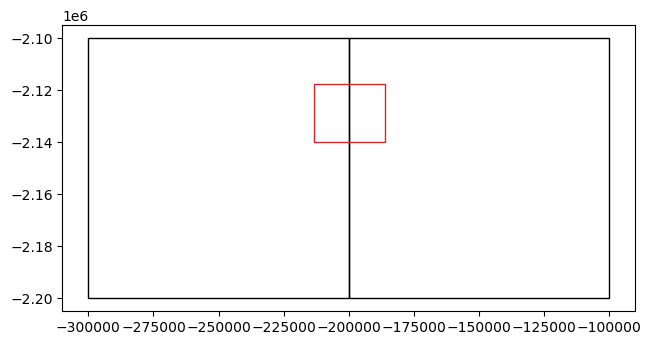

In [5]:

# construct geopandas dataframe
bounds_gdf = gpd.GeoDataFrame(geometry=[box(*bounds)], crs=3413)

# plot using matplotlib
fig, ax = plt.subplots(layout='constrained')
cube_gdf.plot(ax=ax, fc='none', ec='k')
bounds_gdf.plot(ax=ax, fc='none', ec='tab:red')


We will show how we can resolve this later.

# Download mosaics

For now, we must download the tiles using the `itl.mosaic.download_tile()` function. The most important input is the `s3_location`. For cases where only one tile is returned by the  `itl.mosaic.get_tiles()` function, we can simple pass the GeoPandas dataframe directly. 

However, for cases such as these where multiple tiles have been returned, we could also select the row (e.g. `cube_gdf.iloc[i]`, where `i` is the row index of our desired tile) or extract the s3 location directly (`cube_gdf.composites_s3.values[i]`, where `i` is the row index of our desired tile).

We can filter our final download using the `bounds` and `year` options. `year` will accept a single year, or two years resulting in a range.

Lets download the first mosaic, which will be returned as an `xarray` Dataset.

In [6]:
xds_1 = itl.mosaic.download_tile(cube_gdf.iloc[0], bounds=bounds, year=2020)

Xarray loads data lazily - to enforce a download (which will be fine for the small dataset we're playing with here), lets use the `.load()` function:

In [7]:
xds_1 = xds_1.load()

And we can visualise that this looks like:

In [8]:
xds_1

<xarray.Dataset>
Dimensions:   (time: 1, x: 228, y: 188)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-01
  * x         (x) float64 -2.133e+05 -2.132e+05 ... -1.862e+05 -1.861e+05
  * y         (y) float64 -2.118e+06 -2.118e+06 ... -2.14e+06 -2.14e+06
    mapping   int64 0
Data variables:
    v         (time, y, x) float32 1.338 1.39 1.251 1.487 ... nan nan nan nan
    v_error   (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vx        (time, y, x) float32 -0.1558 -0.73 0.1185 0.384 ... nan nan nan
    vx_error  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vy        (time, y, x) float32 1.329 1.183 1.245 1.437 ... nan nan nan nan
    vy_error  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes: (12/20)
    GDAL_AREA_OR_POINT:                Area
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    composites_software_version:       1.0
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    datacube_created:                  26-Sep-2023 02:32:17
    datacube_s3:                       s3://its-live-data/datacubes/v2/N70W05...
    ...                                ...
    longitude:                         -51.63
    proj_polygon:                      [[-300000, -2200000], [-275000.0, -220...
    projection:                        3413
    s3:                                s3://its-live-data/composites/annual/v...
    title:                             ITS_LIVE datacube of image pair veloci...
    url:                               https://its-live-data.s3.amazonaws.com...

Note that by default, the function returns a limited selection of variables ($v$, $v_x$, $v_y$, and their errors). ITS_LIVE offers a much larger range of potential variables which are viewable from within `itl` as the `VARIABLES_ALL` parameter:

In [17]:
itl.__version__

'0.1.0'

To select a custom range of options, you can pass them as a list to the `variables` variable in the `load_mosaic()` function.

We can visualise our velocity using built-in `xarray` functions:

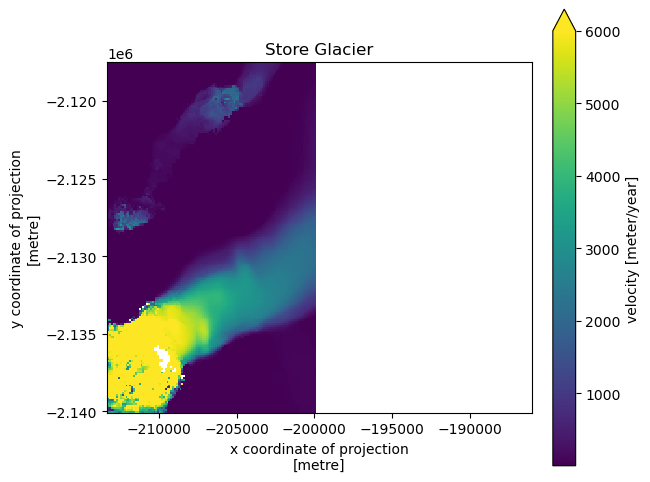

In [10]:
fig, ax = plt.subplots(layout='constrained')
xds_1.v.plot(ax=ax, vmax=6000)
ax.set_title(name)
ax.set_aspect('equal')

We can see that, as expected, this tile only covers half of the ROI. Let's get the other tile and fix this:


# Merging tiles together

As our ROI covers multiple tiles , let's now download the second mosaic tile too, this time downloading the tile at `.iloc[1]` rather than `.iloc[0]`:

In [11]:
xds_2 = itl.mosaic.download_tile(cube_gdf.iloc[1], bounds=bounds, year=2020)
xds_2.load()

<xarray.Dataset>
Dimensions:   (time: 1, x: 228, y: 188)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-01
  * x         (x) float64 -2.133e+05 -2.132e+05 ... -1.862e+05 -1.861e+05
  * y         (y) float64 -2.118e+06 -2.118e+06 ... -2.14e+06 -2.14e+06
    mapping   int64 0
Data variables:
    v         (time, y, x) float32 nan nan nan nan ... 78.64 84.34 90.05 91.15
    v_error   (time, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vx        (time, y, x) float32 nan nan nan nan ... -83.79 -89.23 -90.26
    vx_error  (time, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    vy        (time, y, x) float32 nan nan nan nan ... -9.646 -12.11 -12.71
    vy_error  (time, y, x) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/20)
    GDAL_AREA_OR_POINT:                Area
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    composites_software_version:       1.0
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    datacube_created:                  26-Sep-2023 03:06:33
    datacube_s3:                       s3://its-live-data/datacubes/v2/N70W04...
    ...                                ...
    longitude:                         -48.99
    proj_polygon:                      [[-200000, -2200000], [-175000.0, -220...
    projection:                        3413
    s3:                                s3://its-live-data/composites/annual/v...
    title:                             ITS_LIVE datacube of image pair veloci...
    url:                               https://its-live-data.s3.amazonaws.com...

If we plot them with different colour bars we can see that, as expected, the two tiles are covering two difference sides of the ROI, matching that predicted by the first figure:

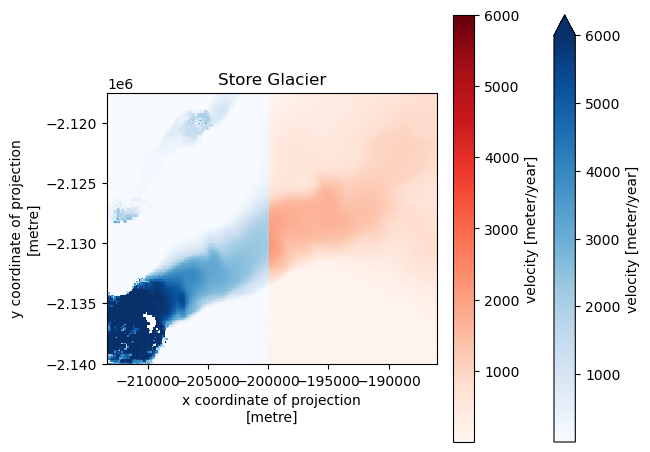

In [12]:
fig, ax = plt.subplots(layout='constrained')
xds_1.v.plot(ax=ax, cmap='Blues', vmax=6000)
xds_2.v.plot(ax=ax, cmap='Reds', vmax=6000)
ax.set_title(name)
ax.set_aspect('equal')

We can merge these datasets by passing a list to the `itl.mosaic.merge_tiles()` function, which is just a wrapper for the `xarray.merge()` function:

In [13]:
xds_merge = itl.mosaic.merge_tiles([xds_1, xds_2])

Now that we've done this, we have one complete dataset:

In [14]:
xds_merge

<xarray.Dataset>
Dimensions:   (time: 1, x: 228, y: 188)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-01
  * x         (x) float64 -2.133e+05 -2.132e+05 ... -1.862e+05 -1.861e+05
  * y         (y) float64 -2.118e+06 -2.118e+06 ... -2.14e+06 -2.14e+06
    mapping   int64 0
Data variables:
    v         (time, y, x) float32 1.338 1.39 1.251 1.487 ... 84.34 90.05 91.15
    v_error   (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vx        (time, y, x) float32 -0.1558 -0.73 0.1185 ... -83.79 -89.23 -90.26
    vx_error  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vy        (time, y, x) float32 1.329 1.183 1.245 ... -9.646 -12.11 -12.71
    vy_error  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GDAL_AREA_OR_POINT:                Area
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    composites_software_version:       1.0
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    datacube_software_version:         1.0
    institution:                       NASA Jet Propulsion Laboratory (JPL), ...
    projection:                        3413
    title:                             ITS_LIVE datacube of image pair veloci...

We can test this by plotting it:

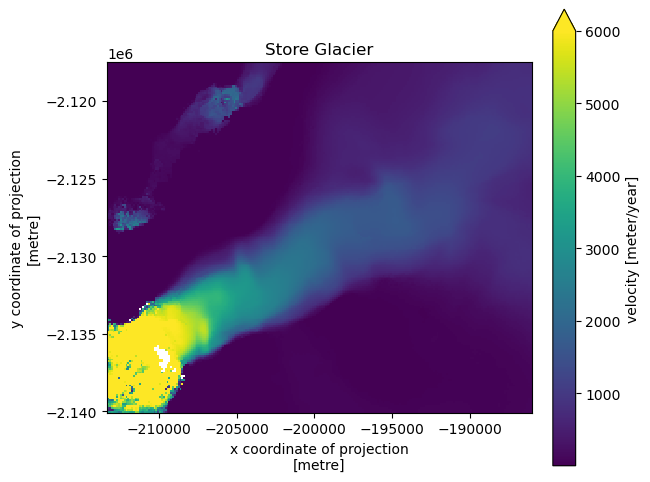

In [15]:
fig, ax = plt.subplots(layout='constrained')
xds_merge.v.plot(ax=ax, vmax=6000)
ax.set_title(name)
ax.set_aspect('equal')

Note that as we have $v_x$ and $v_y$ information, we can plot flow direction as well using matplotlibs `plt.quiver()` function!

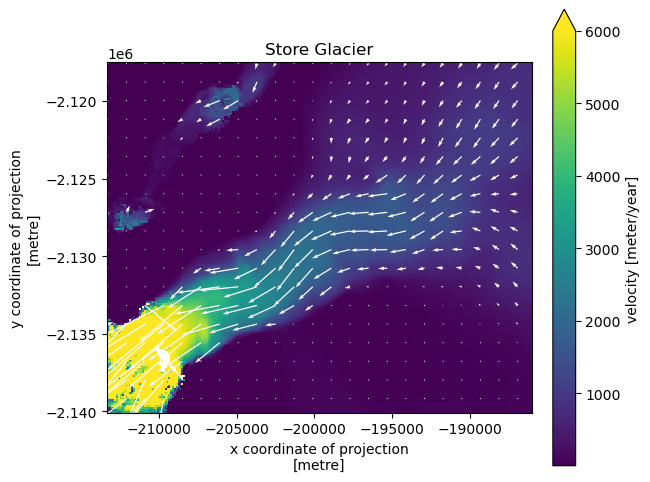

In [16]:
fig, ax = plt.subplots(layout='constrained')

# We first have to squeeze the dataset, removing the `time` dimension.
xds = xds_merge.squeeze()

# Plot background velocity.
xds.v.plot(ax=ax, vmax=6000)

# Plot quivers
show_every = 10 # Plot every Nth quiver as per https://stackoverflow.com/questions/33576572/python-quiver-options
skip = slice(None, None, show_every)
plt.quiver(xds.x[skip], xds.y[skip], xds.vx[skip, skip], xds.vy[skip, skip], color='w')

ax.set_title(name)
ax.set_aspect('equal')

The `xarray` datasets that are returned are fully `rioxarray`-compatible. As a result, we can take advantage of `rioxarray` functionality to save our outputs as rasters if we like:

In [ ]:
xds.v.rio.to_raster(f'{name}_v.tif', compress='ZSTD', predictor=3, zlevel=1)
